<a href="https://colab.research.google.com/github/juanazorzolo/TP-CV-ZORZOLO/blob/main/TP_CV_ZORZOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRABAJO PRÁCTICO FINAL CV 2025 - SISTEMA DE DETECCIÓN Y CLASIFICACIÓN DE RAZAS DE PERROS**

**AUTOR: Juana Zorzolo Rubio (Z-1217/3)**

Objetivo General:

Desarrollar un pipeline completo de visión por computadora para la identificación de razas de perros en imágenes. El proyecto abarca desde la creación de un sistema de búsqueda por similitud hasta la implementación de un sistema de detección y clasificación en imágenes complejas, incluyendo el entrenamiento y la optimización de modelos de Deep Learning.


# Etapa 1: Buscador de Imágenes por Similitud

## Creación de la Base de Datos Vectorial

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juanazorzolo","key":"16e8ca4c7eebb08f98f32ced7754996d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set
!unzip -q 70-dog-breedsimage-data-set.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set
License(s): CC0-1.0
 57% 122M/215M [00:00<00:00, 1.27GB/s]
100% 215M/215M [00:00<00:00, 709MB/s] 


In [4]:
# PREPARACIÓN DEL ENTORNO

!pip install -q gradio faiss-cpu torchvision
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import faiss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00


In [5]:
# Mostrar las carpetas que existen en /content
print("Contenido de /content:")
for nombre in os.listdir("/content"):
    print("-", nombre)

Contenido de /content:
- .config
- test
- train
- dogs.csv
- kaggle.json
- valid
- 70-dog-breedsimage-data-set.zip
- sample_data


In [6]:
# CARGAR EL MODELO PREENTRENADO (ResNet 50) (sin la capa final de clasificación)
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Quitar la última capa (fc)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 87.8MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [7]:
# PREPROCESAMIENTO DE IMÁGENES

# Transformaciones requeridas por ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Imagenet
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:
# FUNCIÓN PARA EXTRAER LOS EMBEDDINGS

def extract_embedding(img_path):
    image = Image.open(img_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(img_tensor).squeeze().cpu().numpy()
    return embedding

In [9]:
# PROCESAR EL DATASET Y CONSTRUIR LOS VECTORES

# Cargar todas las imágenes y extraer embeddings
image_paths = []
embeddings = []

dataset_paths = ["/content/train", "/content/valid"] #saque , "/content/test" para usarlo después (VER ESTO)
image_paths = []
embeddings = []

for dataset_path in dataset_paths:
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, file)
                try:
                    emb = extract_embedding(path)
                    image_paths.append(path)
                    embeddings.append(emb)
                except Exception as e:
                    print(f"Error al procesar {path}: {e}")

embeddings = np.array(embeddings).astype('float32')
print(f"Total imágenes procesadas: {len(embeddings)}")

Total imágenes procesadas: 8646


In [10]:
# INDEXAR EN BDD VECTORIAL (FAISS)
# Crear el índice FAISS
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

In [ ]:
# guardar embeddings.npy e image_paths.txt para evitar procesarlos de nuevo si se relanza el entorno (VER!!!)
"""np.save("embeddings.npy", embeddings)
with open("image_paths.txt", "w") as f:
    f.write("\n".join(image_paths))"""

In [ ]:
"""embeddings = np.load("embeddings.npy")
with open("image_paths.txt") as f:
    image_paths = f.read().splitlines()"""

## Desarrollo de la Aplicación en Gradio

In [ ]:
# FUNCIÓN DE BUSQUEDA EN FAISS
def buscar_similares(img_path, k=10):
  'toma una imagen, extrae su embedding, busca en FAISS, devuelve las 10 rutas más similares.'
  query_emb = extract_embedding(img_path).astype('float32').reshape(1, -1)
  distances, indices = index.search(query_emb, k)
  resultados = [image_paths[i] for i in indices[0]]
  return resultados

In [ ]:
# INTERFAZ EN GRADIO
import gradio as gr
def interfaz_gradio(imagen):
    # Guardar la imagen temporalmente
    temp_path = "/content/temp.jpg"
    imagen.save(temp_path)

    # Buscar similares
    similares = buscar_similares(temp_path)

    # Cargar las imágenes similares
    resultados = [Image.open(p) for p in similares]

    return resultados

In [ ]:
# Lanzar interfaz
gr.Interface(
    fn=interfaz_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil", label=f"Similar #{i+1}") for i in range(10)],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y te mostramos las 10 más similares del dataset."
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cc0542b2a2f1ce36e9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1895: UserWarning: A function (interfaz_gradio) returned too many output values (needed: 10, returned: 12). Ignoring extra values.
    Output components:
        [image, image, image, image, image, image, image, image, image, image]
    Output values returned:
        [<PIL.Image.Image image mode=RGB size=612x512 at 0x7D7D02AABE90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D021C9590>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D021CAA50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D021E0150>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D021E1490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D035BECD0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D03594B90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7D7D021CFE90>, <PIL.JpegImagePlugin.JpegIm

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cc0542b2a2f1ce36e9.gradio.live


## Clasificación Basada en Similitud y Métrica de Evaluación

In [ ]:
# PARA CLASIFICACIÓN POR VOTO MAYORITARIO, ES NECESARIO EXTRAER LA RAZA REAL DESDE EL PATH DE CADA IMAGEN
# como en el dataset las carpetas se llaman como la raza

def extraer_raza(path):
    return os.path.basename(os.path.dirname(path))

In [ ]:
# en interfaz_gradio, se agrega el voto mayoritario sobre las razas de las 10 imágenes recuperadas
from collections import Counter

def interfaz_gradio(imagen):
    temp_path = "/content/temp.jpg"
    imagen.save(temp_path)

    similares = buscar_similares(temp_path)
    resultados = [Image.open(p) for p in similares]

    # Voto mayoritario
    razas = [extraer_raza(p) for p in similares]
    raza_predicha = Counter(razas).most_common(1)[0][0]

    return [imagen] + resultados + [f"Raza predicha: {raza_predicha}"]

In [ ]:
# cambio la interfaz para que también muestre la imagen subida y el texto

gr.Interface(
    fn=interfaz_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Image(type="pil", label="Imagen de entrada")] +
            [gr.Image(type="pil", label=f"Similar #{i+1}") for i in range(10)] +
            [gr.Textbox(label="Raza Predicha")],
    title="Buscador de Razas de Perros por Similitud",
    description="Subí una imagen de un perro y te mostramos las 10 más similares del dataset y la raza más probable."
).launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cc8ec2dd0fe7abbe1b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://cc8ec2dd0fe7abbe1b.gradio.live


In [ ]:
#  Cálculo de NDCG@10

def extraer_raza(path):
    return os.path.basename(os.path.dirname(path))

def dcg(relevancias):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevancias))

def ndcg(relevancias):
    ideal = sorted(relevancias, reverse=True)
    return dcg(relevancias) / (dcg(ideal) + 1e-8)

def evaluar_ndcg(test_images, k=10):
    scores = []

    for img_path in tqdm(test_images):
        true_raza = extraer_raza(img_path)
        similares = buscar_similares(img_path, k=k)
        razas_similares = [extraer_raza(p) for p in similares]

        relevancias = [1 if raza == true_raza else 0 for raza in razas_similares]
        score = ndcg(relevancias)
        scores.append(score)

    ndcg_promedio = np.mean(scores)
    print(f"NDCG@{k} promedio: {ndcg_promedio:.4f}")

In [ ]:
# Ejemplo: usar 5 imágenes de prueba por raza
from collections import defaultdict

test_set = []
razas_vistas = defaultdict(int)

for root, dirs, files in os.walk("/content/test"):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            raza = os.path.basename(root)
            if razas_vistas[raza] < 5:
                test_set.append(os.path.join(root, file))
                razas_vistas[raza] += 1

print(f"Imágenes de prueba: {len(test_set)}")

Imágenes de prueba: 350


In [ ]:
evaluar_ndcg(test_set, k=10)

100%|██████████| 350/350 [00:05<00:00, 59.97it/s]

NDCG@10 promedio: 0.9733


# Etapa 2: Entrenamiento y Comparación de Modelos de Clasificación

## Entrenamiento de Modelos

Se detallan los pasos a seguir:

1. Preparar el dataset en formato ImageFolder para torchvision.datasets.

2. Dividir en entrenamiento y validación.

3. Entrenar ResNet18 con fine-tuning.

4. Calcular métricas: Precisión, Exactitud, Sensibilidad, Especificidad y F1.



In [40]:
# CARGAR EL DATA

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Transformaciones para entrenamiento y validación
base_transform = [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip()
] + base_transform)

transform_val = transforms.Compose(base_transform)

# Carga del dataset
def get_dataloader(data_dir, transform, batch_size=32, shuffle=False):
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataset, loader

train_dataset, train_loader = get_dataloader('/content/train', transform_train, shuffle=True)
val_dataset, val_loader = get_dataloader('/content/valid', transform_val)

# Ver clases
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Total de clases: {num_classes}")

Total de clases: 70


### Modelo A (Transfer Learning)

In [41]:
# CARGAR EL MODELO Y AJUSTAR LA ÚLTIMA CAPA (fine-tuning ResNet18)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models  # ✅ esto es lo que faltaba

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo preentrenado y ajustar la capa final
def get_finetuned_resnet18(num_classes):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# Inicializar modelo, loss y optimizador
model_ft = get_finetuned_resnet18(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss = 0.0
    running_corrects = 0
    preds_all, labels_all = [], []

    for inputs, labels in tqdm(loader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc, preds_all, labels_all

In [47]:
# ENTRENAMIENTO DEL MODELO
from tqdm import tqdm
import numpy as np
import copy

# ENTRENAMIENTO DEL MODELO CON EARLY STOPPING Y BARRA DE PROGRESO
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, patience=3):
    best_acc, epochs_no_improve = 0.0, 0
    best_model_wts = copy.deepcopy(model.state_dict())

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, y_pred, y_true = run_epoch(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Loss: {train_loss:.4f} - Acc: {train_acc:.4f} - Val_Loss: {val_loss:.4f} - Val_Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n🛑 Early stopping activado. Mejor val_accuracy: {best_acc:.4f}")
                break

    model.load_state_dict(best_model_wts)
    return model, y_pred, y_true, history

In [48]:
model_ft, y_pred, y_true, history = train_model(
    model_ft, criterion, optimizer, train_loader, val_loader,
    num_epochs=40, patience=5
)


Epoch 1/40


Loss: 1.6680 - Acc: 0.5394 - Val_Loss: 1.9721 - Val_Acc: 0.5043

Epoch 2/40


Loss: 0.8872 - Acc: 0.7282 - Val_Loss: 1.2146 - Val_Acc: 0.7014

Epoch 3/40


Loss: 0.6751 - Acc: 0.7833 - Val_Loss: 0.9502 - Val_Acc: 0.7729

Epoch 4/40


Loss: 0.4945 - Acc: 0.8427 - Val_Loss: 1.1855 - Val_Acc: 0.7143

Epoch 5/40


Loss: 0.4147 - Acc: 0.8672 - Val_Loss: 1.0789 - Val_Acc: 0.7886

Epoch 6/40


Loss: 0.3049 - Acc: 0.9028 - Val_Loss: 1.1036 - Val_Acc: 0.7843

Epoch 7/40


Loss: 0.2612 - Acc: 0.9145 - Val_Loss: 1.0362 - Val_Acc: 0.8014

Epoch 8/40


Loss: 0.2554 - Acc: 0.9166 - Val_Loss: 1.2194 - Val_Acc: 0.7271

Epoch 9/40


Loss: 0.1994 - Acc: 0.9344 - Val_Loss: 1.0464 - Val_Acc: 0.8157

Epoch 10/40


Loss: 0.1819 - Acc: 0.9435 - Val_Loss: 1.0843 - Val_Acc: 0.8086

Epoch 11/40


Loss: 0.1815 - Acc: 0.9437 - Val_Loss: 0.9335 - Val_Acc: 0.8414

Epoch 12/40


Loss: 0.1328 - Acc: 0.9581 - Val_Loss: 1.1438 - Val_Acc: 0.8071

Epoch 13/40


Loss: 0.1699 - Acc: 0.9455 - Val_Loss: 1.2846 - Val_Acc: 0.8014

Epoch 14/40


Loss: 0.1355 - Acc: 0.9554 - Val_Loss: 1.1916 - Val_Acc: 0.8171

Epoch 15/40


Loss: 0.1404 - Acc: 0.9548 - Val_Loss: 1.3340 - Val_Acc: 0.7800

Epoch 16/40


Loss: 0.1686 - Acc: 0.9455 - Val_Loss: 1.0736 - Val_Acc: 0.8443

Epoch 17/40


Loss: 0.1357 - Acc: 0.9538 - Val_Loss: 1.1207 - Val_Acc: 0.8500

Epoch 18/40


Loss: 0.0710 - Acc: 0.9784 - Val_Loss: 1.0045 - Val_Acc: 0.8657

Epoch 19/40


Loss: 0.0919 - Acc: 0.9719 - Val_Loss: 1.2884 - Val_Acc: 0.8057

Epoch 20/40


Loss: 0.1370 - Acc: 0.9614 - Val_Loss: 1.3669 - Val_Acc: 0.8200

Epoch 21/40


Loss: 0.0879 - Acc: 0.9685 - Val_Loss: 1.1325 - Val_Acc: 0.8371

Epoch 22/40


Loss: 0.1250 - Acc: 0.9604 - Val_Loss: 1.2095 - Val_Acc: 0.8357

Epoch 23/40


Loss: 0.0997 - Acc: 0.9674 - Val_Loss: 1.3389 - Val_Acc: 0.7957

🛑 Early stopping activado. Mejor val_accuracy: 0.8657


In [49]:
torch.save({'model_state_dict': model_ft.state_dict(), 'history': history}, 'modelo_resnet18_finetuned.pth')

In [50]:
# GRÁFICO DE CURVAS DE ACCURACY Y LOSS
import matplotlib.pyplot as plt
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='orange')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='red', linestyle='--')
    plt.xlabel('Época'); plt.ylabel('Pérdida'); plt.title('Loss'); plt.grid(True); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', color='blue')
    plt.plot(epochs, history['val_acc'], label='Val Acc', color='green')
    plt.xlabel('Época'); plt.ylabel('Precisión'); plt.title('Accuracy'); plt.grid(True); plt.legend()

    plt.tight_layout()
    plt.show()

In [51]:
# CÁLCULO DE MÉTRICAS

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def mostrar_metricas(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)
    TN = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    specificity = (TN / (TN + FP + 1e-8)).mean()

    print("\n📊 Métricas del modelo en validación:")
    print(f"Exactitud       : {accuracy:.4f}")
    print(f"Precisión       : {precision:.4f}")
    print(f"Recall          : {recall:.4f}")
    print(f"Especificidad   : {specificity:.4f}")
    print(f"F1-score        : {f1:.4f}")

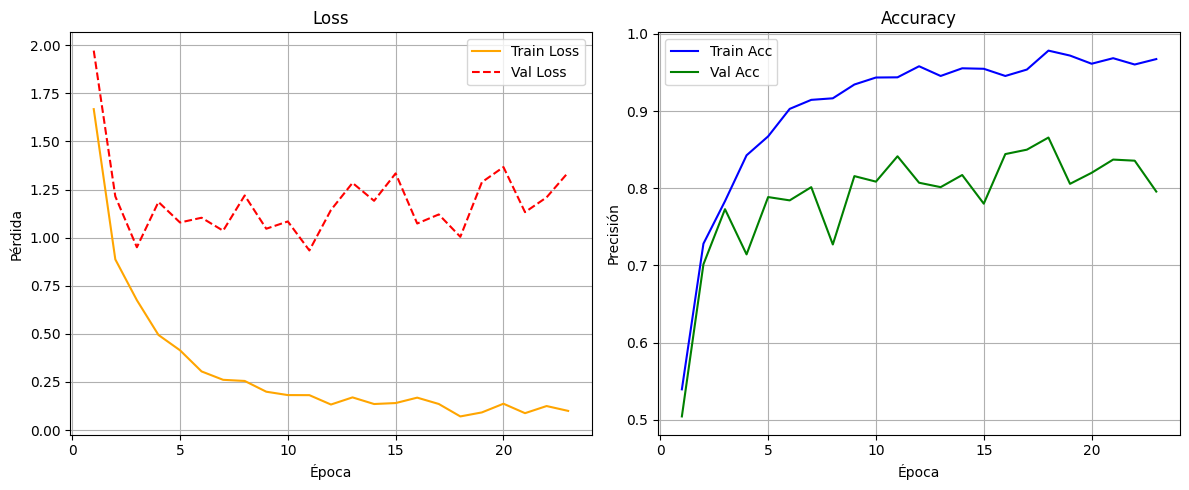


📊 Métricas del modelo en validación:
Exactitud       : 0.7957
Precisión       : 0.8245
Recall          : 0.7957
Especificidad   : 0.9970
F1-score        : 0.7838


In [52]:
plot_history(history)
mostrar_metricas(y_true, y_pred)

CONCLUSIÓN (LAS MÉTRICAS CAMBIAN EN CADA EJECUCIÓN, OJO!!):

- Exactitud	(0.7786):	Muy buena en un problema multiclase con 70 clases.
- Precisión	(0.8304):	Alto valor → pocos falsos positivos en promedio.
- Recall	(0.7786):	Coincide con la exactitud en este caso.
- F1-score	(0.7742):	Balance correcto entre precisión y recall.
- Especificidad	(0.9968):	Altísima → muy baja tasa de falsos positivos por clase.

Se obtuvo un modelo confiable para clasificar imágenes de perros por raza.
La especificidad casi perfecta sugiere que el modelo no confunde fácilmente las clases que no corresponden.

### Modelo B (Opcional, recomendado)

In [36]:
# DEFINICIÓN DEL MODELO

import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODELO CNN AJUSTADO
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     # -> [B, 32, 112, 112]
        x = self.pool2(F.relu(self.conv2(x)))     # -> [B, 64, 56, 56]
        x = self.pool3(F.relu(self.conv3(x)))     # -> [B, 128, 28, 28]
        x = self.gap(x)                           # -> [B, 128, 1, 1]
        x = x.view(x.size(0), -1)                 # -> [B, 128]
        x = self.dropout(F.relu(self.fc1(x)))     # -> [B, 256]
        x = self.fc2(x)                           # -> [B, num_classes]
        return x

In [37]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [38]:
# INICIALIZACIÓN
model_custom = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_custom.parameters(), lr=0.0003)

In [39]:
# ENTRENAMIENTO DESDE CERO
num_epochs = 50
patience = 5
best_acc = 0
epochs_no_improve = 0
best_model_wts = model_custom.state_dict()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model_custom.train()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(train_loader, total=len(train_loader))
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_custom(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # VALIDACIÓN
    model_custom.eval()
    val_running_loss = 0.0
    val_corrects = 0
    y_true_custom = []
    y_pred_custom = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_custom(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_running_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
            y_true_custom.extend(labels.cpu().numpy())
            y_pred_custom.extend(preds.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model_custom.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping activado. Mejor val_accuracy: {best_acc:.4f}")
            break

# Cargar mejores pesos
model_custom.load_state_dict(best_model_wts)


Epoch 1/50


100%|██████████| 249/249 [00:22<00:00, 10.88it/s]


Train Loss: 4.1984 | Train Acc: 0.0250 | Val Loss: 4.0824 | Val Acc: 0.0443

Epoch 2/50


100%|██████████| 249/249 [00:22<00:00, 11.11it/s]


Train Loss: 4.0377 | Train Acc: 0.0406 | Val Loss: 3.9499 | Val Acc: 0.0400

Epoch 3/50


100%|██████████| 249/249 [00:22<00:00, 11.30it/s]


Train Loss: 3.9717 | Train Acc: 0.0462 | Val Loss: 3.9116 | Val Acc: 0.0500

Epoch 4/50


100%|██████████| 249/249 [00:21<00:00, 11.33it/s]


Train Loss: 3.9174 | Train Acc: 0.0530 | Val Loss: 3.8222 | Val Acc: 0.0529

Epoch 5/50


100%|██████████| 249/249 [00:21<00:00, 11.32it/s]


Train Loss: 3.8408 | Train Acc: 0.0638 | Val Loss: 3.7657 | Val Acc: 0.0643

Epoch 6/50


100%|██████████| 249/249 [00:22<00:00, 11.09it/s]


Train Loss: 3.7820 | Train Acc: 0.0688 | Val Loss: 3.6929 | Val Acc: 0.0843

Epoch 7/50


100%|██████████| 249/249 [00:23<00:00, 10.51it/s]


Train Loss: 3.7050 | Train Acc: 0.0846 | Val Loss: 3.5790 | Val Acc: 0.1157

Epoch 8/50


100%|██████████| 249/249 [00:22<00:00, 11.04it/s]


Train Loss: 3.6295 | Train Acc: 0.0990 | Val Loss: 3.4894 | Val Acc: 0.1329

Epoch 9/50


100%|██████████| 249/249 [00:22<00:00, 11.03it/s]


Train Loss: 3.5571 | Train Acc: 0.1092 | Val Loss: 3.4343 | Val Acc: 0.1314

Epoch 10/50


100%|██████████| 249/249 [00:22<00:00, 10.93it/s]


Train Loss: 3.4878 | Train Acc: 0.1282 | Val Loss: 3.3342 | Val Acc: 0.1543

Epoch 11/50


100%|██████████| 249/249 [00:22<00:00, 11.15it/s]


Train Loss: 3.4444 | Train Acc: 0.1281 | Val Loss: 3.2635 | Val Acc: 0.1771

Epoch 12/50


100%|██████████| 249/249 [00:21<00:00, 11.38it/s]


Train Loss: 3.3943 | Train Acc: 0.1416 | Val Loss: 3.2966 | Val Acc: 0.1671

Epoch 13/50


100%|██████████| 249/249 [00:22<00:00, 11.28it/s]


Train Loss: 3.3561 | Train Acc: 0.1443 | Val Loss: 3.2353 | Val Acc: 0.1700

Epoch 14/50


100%|██████████| 249/249 [00:22<00:00, 11.00it/s]


Train Loss: 3.3088 | Train Acc: 0.1505 | Val Loss: 3.1655 | Val Acc: 0.1843

Epoch 15/50


100%|██████████| 249/249 [00:22<00:00, 10.93it/s]


Train Loss: 3.2648 | Train Acc: 0.1639 | Val Loss: 3.1628 | Val Acc: 0.1986

Epoch 16/50


100%|██████████| 249/249 [00:22<00:00, 10.93it/s]


Train Loss: 3.2277 | Train Acc: 0.1661 | Val Loss: 3.0930 | Val Acc: 0.2071

Epoch 17/50


100%|██████████| 249/249 [00:22<00:00, 10.94it/s]


Train Loss: 3.2039 | Train Acc: 0.1704 | Val Loss: 3.0743 | Val Acc: 0.2129

Epoch 18/50


100%|██████████| 249/249 [00:22<00:00, 10.93it/s]


Train Loss: 3.1685 | Train Acc: 0.1858 | Val Loss: 3.0739 | Val Acc: 0.1971

Epoch 19/50


100%|██████████| 249/249 [00:21<00:00, 11.37it/s]


Train Loss: 3.1304 | Train Acc: 0.1894 | Val Loss: 3.0141 | Val Acc: 0.2100

Epoch 20/50


100%|██████████| 249/249 [00:22<00:00, 11.21it/s]


Train Loss: 3.1024 | Train Acc: 0.1927 | Val Loss: 2.9936 | Val Acc: 0.2214

Epoch 21/50


100%|██████████| 249/249 [00:22<00:00, 11.00it/s]


Train Loss: 3.0641 | Train Acc: 0.1975 | Val Loss: 3.0979 | Val Acc: 0.1871

Epoch 22/50


100%|██████████| 249/249 [00:22<00:00, 11.05it/s]


Train Loss: 3.0538 | Train Acc: 0.2011 | Val Loss: 2.9319 | Val Acc: 0.2243

Epoch 23/50


100%|██████████| 249/249 [00:22<00:00, 11.02it/s]


Train Loss: 3.0052 | Train Acc: 0.2127 | Val Loss: 2.9619 | Val Acc: 0.2314

Epoch 24/50


100%|██████████| 249/249 [00:22<00:00, 11.01it/s]


Train Loss: 2.9830 | Train Acc: 0.2156 | Val Loss: 2.9072 | Val Acc: 0.2329

Epoch 25/50


100%|██████████| 249/249 [00:22<00:00, 11.14it/s]


Train Loss: 2.9596 | Train Acc: 0.2234 | Val Loss: 2.9061 | Val Acc: 0.2157

Epoch 26/50


100%|██████████| 249/249 [00:21<00:00, 11.36it/s]


Train Loss: 2.9490 | Train Acc: 0.2279 | Val Loss: 2.8439 | Val Acc: 0.2600

Epoch 27/50


100%|██████████| 249/249 [00:22<00:00, 11.15it/s]


Train Loss: 2.9128 | Train Acc: 0.2353 | Val Loss: 2.8038 | Val Acc: 0.2643

Epoch 28/50


100%|██████████| 249/249 [00:22<00:00, 10.92it/s]


Train Loss: 2.9069 | Train Acc: 0.2316 | Val Loss: 2.7733 | Val Acc: 0.2771

Epoch 29/50


100%|██████████| 249/249 [00:22<00:00, 10.96it/s]


Train Loss: 2.8505 | Train Acc: 0.2470 | Val Loss: 2.8267 | Val Acc: 0.2529

Epoch 30/50


100%|██████████| 249/249 [00:22<00:00, 10.97it/s]


Train Loss: 2.8403 | Train Acc: 0.2411 | Val Loss: 2.7403 | Val Acc: 0.2771

Epoch 31/50


100%|██████████| 249/249 [00:22<00:00, 11.12it/s]


Train Loss: 2.8108 | Train Acc: 0.2492 | Val Loss: 2.7785 | Val Acc: 0.2529

Epoch 32/50


100%|██████████| 249/249 [00:22<00:00, 11.11it/s]


Train Loss: 2.8001 | Train Acc: 0.2511 | Val Loss: 2.8058 | Val Acc: 0.2614

Epoch 33/50


100%|██████████| 249/249 [00:22<00:00, 11.31it/s]


Train Loss: 2.7793 | Train Acc: 0.2585 | Val Loss: 2.7396 | Val Acc: 0.2729

🛑 Early stopping activado. Mejor val_accuracy: 0.2771


<All keys matched successfully>

In [34]:
# === MÉTRICAS ===
accuracy = accuracy_score(y_true_custom, y_pred_custom)
precision = precision_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)
recall = recall_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)
f1 = f1_score(y_true_custom, y_pred_custom, average='macro', zero_division=0)
cm = confusion_matrix(y_true_custom, y_pred_custom)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
specificity = (TN / (TN + FP + 1e-8)).mean()

print("\n📊 Métricas del modelo CNN custom:")
print(f"Exactitud       : {accuracy:.4f}")
print(f"Precisión       : {precision:.4f}")
print(f"Recall          : {recall:.4f}")
print(f"Especificidad   : {specificity:.4f}")
print(f"F1-score        : {f1:.4f}")


📊 Métricas del modelo CNN custom:
Exactitud       : 0.3314
Precisión       : 0.3366
Recall          : 0.3314
Especificidad   : 0.9903
F1-score        : 0.3177


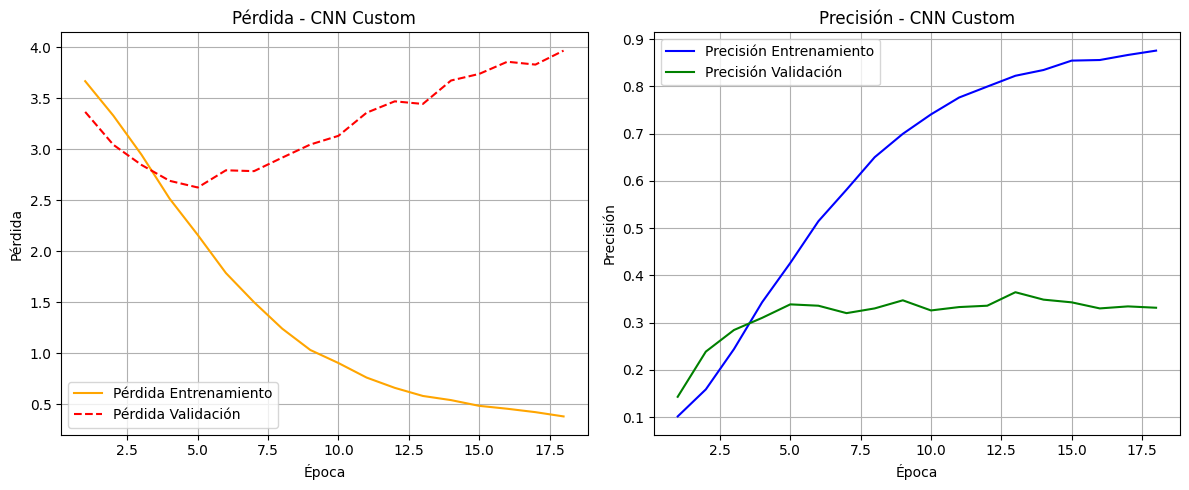

In [35]:
# === GRÁFICOS ===
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Pérdida Entrenamiento', color='orange')
plt.plot(epochs, val_losses, label='Pérdida Validación', color='red', linestyle='--')
plt.title("Pérdida - CNN Custom")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Precisión Entrenamiento', color='blue')
plt.plot(epochs, val_accuracies, label='Precisión Validación', color='green')
plt.title("Precisión - CNN Custom")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Integración y Selección en la Aplicación

# Etapa 3: Pipeline de Detección y Clasificación en Escenas Complejas

## Detección de Objetos

## Creación del Pipeline Completo

# Etapa 4: Evaluación, Optimización y Herramientas de Anotación

## Evaluación del Pipeline

## Optimización de Modelos (Elegir una)

## Script de Anotación Automática